# Exercise Class Week 6: Simplex Walk-through
Tian You <br>
[tiayou@ethz.ch](mailto:tiayou@ethz.ch)<br>
27.10.2021 <br>

In [1]:
# Import the module
import numpy as np

# Implement the pivot function
def pivot(T,i,k):
    # Create a copy of the tableau
    T_pivot = np.copy(T)
    
    # Step (i)
    # We divide the i-th row elementwise by the value of a_ik
    T_pivot[i,:] = T[i,:] / T[i,k]
    
    # Step (ii)
    # Note: for-loops can be interchanged
    # We iterate through each column (l = 1,...,n+m)
    for l in range(0,T.shape[1]):
        # In the column we iterate through each row, but skip row i (j=/=i,j=1,...,m)
        for j in range(0,T.shape[0]):
            if(j!=i):
                # We compute the new value
                T_pivot[j,l] = T[j,l] - T[j,k] * T[i,l] / T[i,k]
    
    return T_pivot  

In [2]:
# Implement the second phase of the simplex algorithm

def simplexphase2_v2(T, header=None, verbose=True, orig_obj=False):
    
    """Perform the phase 2 of simplex algorithm given a FEASIBLE tableau T.

    Args:
      - T: A numpy matrix representing the starting feasible tableau.
      - header: A numpy array representing the column names of the tableau. 
        Used for printing only. The default value is None.
      - verbose: A boolean indicating whether to print the details.
        The default value is True (print all output).
      - orig_obj: A boolean indicating whether we keep the extra line for
        the original objective function in the LP. Applicable to Phase 1 only.

    Returns:
      T: A numpy array representing the resulting matrix from the simplex algorithm.
      past_T: A list of intermediate tableaus.
    """
    past_T = [T]
    num_col = T.shape[1]
    num_row = T.shape[0]
    
    step_counter = 0 # to count the steps in our simplex algorithm; for printing only
    
    offset = 1 if orig_obj else 0
    
    if verbose:
        print("Input:")
        if header is not None:
            print("", header)
        print(T, "\n")
        
    while True:
    
        # If all numbers (except the last column) in the objective row >=0,
        # then we have found an optimal solution and will end the algorithm.
        if (T[0,:-1] >= 0).all():
            print("We found an optimal solution!")
            return T, past_T   

        # If any column has an entry <0 in the objective row, and all other entries are <= 0,
        # then it means the tableau (and the LP) is unbounded, and we will end the algorithm.
        for j in range(0, num_col-1):
            if (T[0,j] < 0) and (T[1+offset:,j] <= 0).all():
                print("The LP is unbounded.")
                return T, past_T
 
        # If the tableau is neither unbounded nor optimal, then we can continue
        # with the second phase of the simplex algorithm.
        step_counter += 1
        if verbose:
            print(f"****** Step {step_counter} ******")

        # determine the pivot column (choose the most negative entry)
        min_obj = np.inf
        pivot_col = np.inf
        for j in range(0, num_col-1):
            if T[0,j] < min_obj:
                min_obj = T[0,j]
                pivot_col = j
        if verbose:
            if header is None:
                pivot_col_name = "#" + str(pivot_col+1)
            else:
                pivot_col_name = header[pivot_col] 
            print(f"Pivot col: column {pivot_col_name} "  + 
                  f"as it has the most negative value " +
                  f"{min_obj:.2f} in the obj row.")

        # determine the pivot row (use the quotient rule)
        min_ratio = np.inf
        pivot_row = np.inf
        for i in range(1+offset, num_row):
            if T[i,pivot_col] > 0:
                ratio = T[i,-1] / T[i,pivot_col]
                if ratio < min_ratio:
                    min_ratio = ratio
                    pivot_row = i   
        if verbose:
            print(f"Pivot row: constraint row #{pivot_row-offset} " + 
                  f"based on the quotient rule as it has " +
                  f"the smallest ratio {min_ratio:.2f}.")

        # perform the pivoting step
        T = pivot(T, pivot_row, pivot_col)
        past_T.append(T.copy())
        if verbose:
            if header is not None: 
                print("", header)
            print(T, "\n")


In [3]:
# Adjust the printing format
np.set_printoptions(
    formatter={'str_kind': lambda x: '{:^7}'.format(x),
               'float': lambda x: '{: ^7.3g}'.format(x)})

## Our Problem

Consider the following LP:
$$\begin{equation}
\begin{array}{llrrrrrrrr}
  &\text{max} \quad z= &  x_1 & + &  x_2 &       &    \\
  &\text{s. t.:}       &-4x_1 & - &  x_2 & \leq  & -8 \\
  &                    & -x_1 & + &  x_2 & \leq  &  3 \\
  &                    &      & - &  x_2 & \leq  & -2 \\
  &                    & 2x_1 & + &  x_2 & \leq  & 12 \\
  &                    &  x_1 &   &      & \geq  &  0 \\
  &                    &      &   &  x_2 & \geq  &  0 \\
\end{array}
\end{equation}$$

In [4]:
import pulp

Lp1 = pulp.LpProblem("My_LP_1", pulp.LpMaximize)

x1 = pulp.LpVariable('x1', lowBound=0, cat=pulp.LpContinuous)
x2 = pulp.LpVariable('x2', lowBound=0, cat=pulp.LpContinuous)

Lp1 +=    x1 +   x2

Lp1 += -4*x1 - 1*x2 <= -8
Lp1 += -1*x1 + 1*x2 <=  3
Lp1 +=       - 1*x2 <= -2
Lp1 +=  2*x1 + 1*x2 <= 12

Lp1.solve()
print(f"An optimal solution to the LP is ({x1.value():.2f},{x2.value():.2f}) " +
      f"with objective value {Lp1.objective.value():.2f}.")

An optimal solution to the LP is (3.00,6.00) with objective value 9.00.


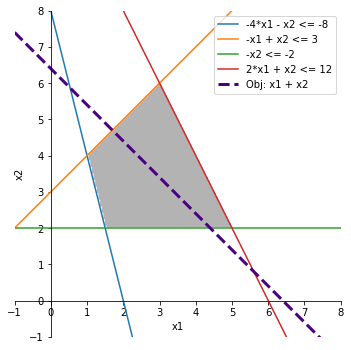

In [5]:
%matplotlib inline
from plotLP import *  
plotLP(Lp1, x_lower=-1, x_upper=8, y_lower=-1, y_upper=8)

## Step 1: Conversion to Standard Form

Consider the following LP:
$$\begin{equation}
\begin{array}{llrrrrrrrr}
  &\text{max} \quad z= &  x_1 & + &  x_2 &       &    \\
  &\text{s. t.:}       &-4x_1 & - &  x_2 & \leq  & -8 \\
  &                    & -x_1 & + &  x_2 & \leq  &  3 \\
  &                    &      & - &  x_2 & \leq  & -2 \\
  &                    & 2x_1 & + &  x_2 & \leq  & 12 \\
  &                    &  x_1 &   &      & \geq  &  0 \\
  &                    &      &   &  x_2 & \geq  &  0 \\
\end{array}
\end{equation}$$

**Can you write down the LP in standard form?**

Recall that a general LP in standard form looks as follows:

$$\begin{equation}
\begin{array}{llrcrcrl}
  &\text{max} \quad z= &     &   & \sum_{j=1}^n c_j  x_j   &    &        \\
  &\text{s. t.:}       & s_i & + & \sum_{j=1}^n a_{ij} x_j &  = &  b_i & \forall i=1,\dots,m\\
  &                    &     &   &                   x_j   &\geq&  0   & \forall j=1,\dots,n\\
  &                    & s_i &   &                         &\geq&  0   & \forall i=1,\dots,m\\
\end{array}
\end{equation}$$

<font color='#85929E'>
Answer: The LP in standard form is:
$$\begin{equation}
\begin{array}{llrrrrrrrrrrrrrl}
  &\text{max} \quad z= &&&&&&&&&  x_1 & + &  x_2 &       &    \\
  &\text{s. t.:}       &s_1 &&&&&&& -& 4x_1 & - &  x_2 & =  & -8 \\
  &                    &&&s_2 &&&&& -&  x_1 & + &  x_2 & =  &  3 \\
  &                    &&&&&s_3 &&&  &      & - &  x_2 & =  & -2 \\
  &                    &&&&&&&s_4 & +& 2x_1 & + &  x_2 & =  & 12 \\
  &                    &      &   &&&&&&&  x_j &&& \geq  &  0 & \forall j = 1,2 \\
  &                    &  s_i &   &&&&&&&&&&       \geq  &  0 & \forall i = 1,2,3,4\\
\end{array}
\end{equation}$$
</font> 

Note that if the original tableau is not in the canonical form, then it is usually easier and clearer to turn it in the canonical form first, and then turn it into the standard form.

## Step 2: Conversion to Tableau

**Can you write down the corresponding tableau?**

<font color='#85929E'>
Answer: The corresponding tableau is:
$$T_0=\begin{equation}
\begin{array}{r|rrrrrr|r}
  z& s_1 & s_2 & s_3 & s_4 & x_1 & x_2 & 1 \\ \hline
    & 0 &  0  &  0  &  0  &-1 &-1 &  0 \\ \hline
    & 1 &  0  &  0  &  0  &-4 &-1 & -8 \\
    & 0 &  1  &  0  &  0  &-1 & 1 &  3 \\
    & 0 &  0  &  1  &  0  & 0 &-1 & -2 \\
    & 0 &  0  &  0  &  1  & 2 & 1 & 12
\end{array}
\end{equation}$$
</font>

Note that here we did not write out the first column $(1,0,0,0,0)^T$ for $z$ as it will not change during the simplex algorithm, but it is perfectly fine if you fill in the first column.

In [6]:
#Add a header
header_org = np.array(['s1','s2','s3','s4','x1','x2','1']) 

#Intialize T0
T0 = np.matrix([
    [0, 0, 0, 0,-1,-1, 0],
    [1, 0, 0, 0,-4,-1,-8],
    [0, 1, 0, 0,-1, 1, 3],
    [0, 0, 1, 0, 0,-1,-2],
    [0, 0, 0, 1, 2, 1,12]
],dtype=float)

#Print the header and T0
print("", header_org)
print(T0)

 [  s1      s2      s3      s4      x1      x2       1   ]
[[   0       0       0       0      -1      -1       0   ]
 [   1       0       0       0      -4      -1      -8   ]
 [   0       1       0       0      -1       1       3   ]
 [   0       0       1       0       0      -1      -2   ]
 [   0       0       0       1       2       1      12   ]]


## Step 3: Feasibility Check & Simplex Phase I

**Is the tableau feasible?** <br>
<font color='#85929E'>
Answer: No, because there are negative entries $-8$ and $-2$ on the RHS. <br>
</font>
Recall the definition: A tableau is feasible if $b_1,\dots,b_m\geq0$, i.e., if the corresponding basic solution is feasible.

To see if we can turn the tableau into a feasible one, we introduce the auxiliary LP:

$$\begin{equation}
\begin{array}{llrrrrrrrl}
  &\text{max} \quad \tilde z = &     &   &                      & - & x_0 &    &      \\
  &\text{s. t.:}       &     &   & \sum_{j=1}^n a_j x_j & - & x_0 &\leq  &  b_i & \forall i=1,\dots,m\\
  &                    &     &   &                      &   & x_j &\geq&  0 & \forall j=0,\dots,n\\
\end{array}
\end{equation}$$

By introducing slack variables $s_i$, we can write the auxiliary problem in standard form:

$$\begin{equation}
\begin{array}{llrrrrrrrl}
  &\text{max} \quad \tilde z = &     &   &                      & - & x_0 &    &      \\
  &\text{s. t.:}       & s_i & + & \sum_{j=1}^n a_j x_j & - & x_0 & =  &  b_i & \forall i=1,\dots,m\\\\
  &                    &     &   &                      &   & x_j &\geq&  0 & \forall j=0,\dots,n\\
  &                    & s_i &   &                      &   &     &\geq&  0 & \forall i=1,\dots,m\\
\end{array}
\end{equation}$$


The corresponding tableau is then:
$$T_{0\:aux}=\begin{equation}
\begin{array}{r|rrrrrrr|r}
            & s_1 & s_2 & s_3 & s_4 & x_1 & x_2 & x_0 &  1 \\ \hline
  \tilde z  &  0  &  0  &  0  &  0  &  0  &  0  &   1 &  0 \\ \hline
         z  &  0  &  0  &  0  &  0  & -1  & -1  &   0 &  0 \\ \hline
            &  1  &  0  &  0  &  0  & -4  & -1  &  -1 & -8 \\
            &  0  &  1  &  0  &  0  & -1  &  1  &  -1 &  3 \\
            &  0  &  0  &  1  &  0  &  0  & -1  &  -1 & -2 \\
            &  0  &  0  &  0  &  1  &  2  &  1  &  -1 & 12
\end{array}
\end{equation}$$

In the lecture, it was mentioned that we can use an extra row to track the objective function of the original LP, and we demonstrate the method here by adding the second row $(0, 0, 0, 0, -1, -1, 0)$. The entries in this row can not be chosen as an entry for pivoting, but we will update its values like we normally do using row operations.

You have also seen that we can pivot without the original objective function, and then recover the original objective function through linear equations. The two methods will give out same results, as we will show below.

In [7]:
#Add a header
header_aux = np.array(['s1','s2','s3','s4','x1','x2','x0','1']) 

#Intialize T0
T0_aux = np.matrix([
    [0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0,-1,-1, 0, 0],
    [1, 0, 0, 0,-4,-1,-1,-8],
    [0, 1, 0, 0,-1, 1,-1, 3],
    [0, 0, 1, 0, 0,-1,-1,-2],
    [0, 0, 0, 1, 2, 1,-1,12]
],dtype=float)

#Print the header and T0
print("", header_aux)
print(T0_aux)

 [  s1      s2      s3      s4      x1      x2      x0       1   ]
[[   0       0       0       0       0       0       1       0   ]
 [   0       0       0       0      -1      -1       0       0   ]
 [   1       0       0       0      -4      -1      -1      -8   ]
 [   0       1       0       0      -1       1      -1       3   ]
 [   0       0       1       0       0      -1      -1      -2   ]
 [   0       0       0       1       2       1      -1      12   ]]


**How can we choose the pivot entry to make the tableau feasible?** <br>
<font color='#85929E'>
Answer: We choose $x_0$ as the pivot column, and the row with the most negative $b_i$ as the pivot row. In other words, it is $(3,7)$, or `(2,6)` using Python's indexing system. <br>
</font>

In [8]:
T1_aux = pivot(T0_aux, 2, 6)
print("", header_aux)
print(T1_aux)

 [  s1      s2      s3      s4      x1      x2      x0       1   ]
[[   1       0       0       0      -4      -1       0      -8   ]
 [   0       0       0       0      -1      -1       0       0   ]
 [  -1      -0      -0      -0       4       1       1       8   ]
 [  -1       1       0       0       3       2       0      11   ]
 [  -1       0       1       0       4       0       0       6   ]
 [  -1       0       0       1       6       2       0      20   ]]


Then we perform the regular steps of Simplex Phase II to maximize $x_0$.

In [9]:
Tf_aux, past_T_aux = simplexphase2_v2(T1_aux, header=header_aux, orig_obj=True)

Input:
 [  s1      s2      s3      s4      x1      x2      x0       1   ]
[[   1       0       0       0      -4      -1       0      -8   ]
 [   0       0       0       0      -1      -1       0       0   ]
 [  -1      -0      -0      -0       4       1       1       8   ]
 [  -1       1       0       0       3       2       0      11   ]
 [  -1       0       1       0       4       0       0       6   ]
 [  -1       0       0       1       6       2       0      20   ]] 

****** Step 1 ******
Pivot col: column x1 as it has the most negative value -4.00 in the obj row.
Pivot row: constraint row #3 based on the quotient rule as it has the smallest ratio 1.50.
 [  s1      s2      s3      s4      x1      x2      x0       1   ]
[[   0       0       1       0       0      -1       0      -2   ]
 [ -0.25     0     0.25      0       0      -1       0      1.5  ]
 [   0      -0      -1      -0       0       1       1       2   ]
 [ -0.25     1     -0.75     0       0       2       0      6.5 

We found an optimal solution, and the optimal value of $x_0$ is $0$. It means that our orginal tableau is feasible. 

Note that $x_0$ is not a basic variable in this case, and we can erase this column from the tableau. If $x_0$ is basic, then we have to perform another pivoting step to remove it from the basis.

### Objective Function of the Original Tableau

As we have mentioned above, there are two ways to derive the objective function of the original tableau:
1. If we have kept the original objective function in the auxilary tableau, then we can read it off directly: $z-0.25s_1-0.75s_3+x_0=3.5$. After removing $x_0$ from the objective function, it becomes $z-0.25s_1-0.75s_3=3.5$.
2. Using the linear equations in the last tableau. The goal is to write the objective function in terms of non-basic variables only.
   - From the first row of the constraints, we can read that $-s_3+x_2+x_0=2$, or $x_2=2+s_3-x_0$.
   - From the second last row of the constraints, we can read that $-0.25s_1+0.25s_3+x_1=1.5$, or $x_1=1.5+0.25s_1-0.25s_3$.
   - The original objective function is then $z=x_1+x_2=1.5+0.25s_1-0.25s_3+2+s_3=3.5+0.25s_1+0.75s_3$, or $z-0.25s_1-0.75s_3=3.5$.

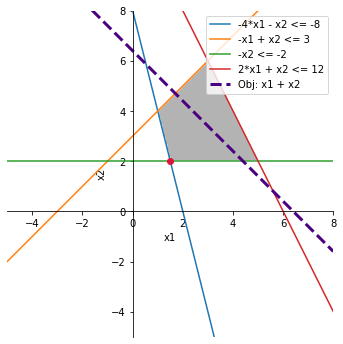

In [10]:
plotLP(Lp1, x_lower=-5, x_upper=8, y_lower=-5, y_upper=8)
plotVert(Tf_aux, x_col_num=4, y_col_num=5)

Now we write down the feasible tableau of our original LP by deleting the objective row of the auxilary LP and the $x_0$ column. 

In [11]:
T1_org = np.copy(Tf_aux)
T1_org = np.delete(T1_org, 0, axis = 0)
T1_org = np.delete(T1_org, 6, axis = 1)
print("", header_org)
print(T1_org)

 [  s1      s2      s3      s4      x1      x2       1   ]
[[ -0.25     0     -0.75     0       0       0      3.5  ]
 [   0      -0      -1      -0       0       1       2   ]
 [ -0.25     1     1.25      0       0       0      2.5  ]
 [ -0.25     0     0.25      0       1       0      1.5  ]
 [  0.5      0      0.5      1       0       0       7   ]]


## Step 4: Simplex Phase II

We stop the algorithm if the tableau is
1. Optimal: If $a_{0j} \geq 0$ for every $j=1,\dots,n$ <br>
**OR** <br>

2. Unbounded: If there exists a column index $k\in{1,\dots,n}$ such that $a_{0k} \le 0$ and $a_{ik} \leq 0$ for every $i=1,\dots,m$ <br>
If the tableau is unbounded, then the LP **must be** unbounded.

Otherwise we keep pivoting using the following rule:
- Choose the column $j$ s.t. $a_{0j} \le 0$ and $\exists i\in \{1,\dots,m\}$ with $a_{i,j}>0$.
- Choose the row $i$ according to the quotient rule / ratio test, where $\frac{b_i}{a_{i,j}}$ is the smallest among $a_{i,j}>0, i\in \{1,\dots,m\}$.

In [12]:
Tf_org, past_T_org = simplexphase2_v2(T1_org, header=header_org)

Input:
 [  s1      s2      s3      s4      x1      x2       1   ]
[[ -0.25     0     -0.75     0       0       0      3.5  ]
 [   0      -0      -1      -0       0       1       2   ]
 [ -0.25     1     1.25      0       0       0      2.5  ]
 [ -0.25     0     0.25      0       1       0      1.5  ]
 [  0.5      0      0.5      1       0       0       7   ]] 

****** Step 1 ******
Pivot col: column s3 as it has the most negative value -0.75 in the obj row.
Pivot row: constraint row #2 based on the quotient rule as it has the smallest ratio 2.00.
 [  s1      s2      s3      s4      x1      x2       1   ]
[[ -0.4     0.6      0       0       0       0       5   ]
 [ -0.2     0.8      0       0       0       1       4   ]
 [ -0.2     0.8      1       0       0       0       2   ]
 [ -0.2    -0.2      0       0       1       0       1   ]
 [  0.6    -0.4      0       1       0       0       6   ]] 

****** Step 2 ******
Pivot col: column s1 as it has the most negative value -0.40 in the o

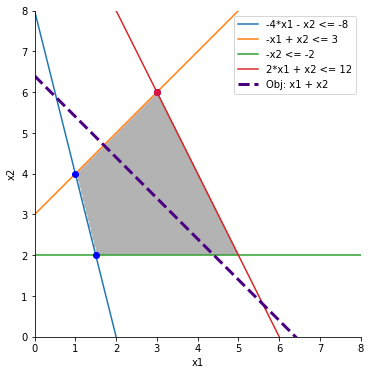

In [13]:
plotLP(Lp1, x_lower=0, x_upper=8, y_lower=0, y_upper=8)
plotVert(Tf_org, past_T=past_T_org, x_col_num=4, y_col_num=5)

## Appendix: the Auxiliary Variable $x_0$
In the original tableau, $(x_1,~x_2)$ is almost always non-basic, so the basic solution $(x_1,~x_2)=(0,0)$ will almost always correspond to the origin in the graph. If the feasible region does not contain the origin, then we are starting with an infeasible tableau.

Choosing $c>0$ means moving all constraints away from the center of the feasible region. If we chose $c=\min\{b_i\}$, the feasible region hits the origin and thus, the corresponding basic soluiton $(x_1,~x_2)=(0,0)$ becomes feasible. To get rid of $c$ again, phase 1 uses pivot until $c=0$.

Consider the following LP with a constant $c$:
$$\begin{equation}
\begin{array}{llrrrrrrrr}
  &\text{max} \quad z= &  x_1 & + &  x_2 &       &    \\
  &\text{s. t.:}       &-4x_1 & - &  x_2 & \leq  & -8 + c \\
  &                    & -x_1 & + &  x_2 & \leq  &  3 + c \\
  &                    &      & - &  x_2 & \leq  & -2 + c \\
  &                    & 2x_1 & + &  x_2 & \leq  & 12 + c \\
  &                    &  x_1 &   &      & \geq  &  0 \\
  &                    &      &   &  x_2 & \geq  &  0 \\
\end{array}
\end{equation}$$

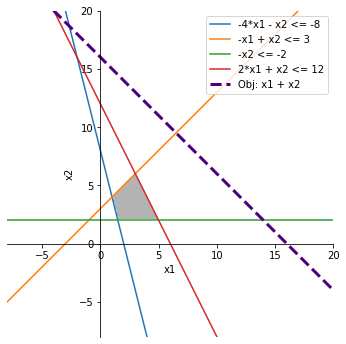

In [14]:
c = 0

Lp2 = pulp.LpProblem("My_LP_2", pulp.LpMaximize)

x1 = pulp.LpVariable('x1', lowBound=0, cat=pulp.LpContinuous)
x2 = pulp.LpVariable('x2', lowBound=0, cat=pulp.LpContinuous)

Lp2 +=    x1 +   x2

Lp2 += -4*x1 - 1*x2 <= -8+c
Lp2 += -1*x1 + 1*x2 <=  3+c
Lp2 +=       - 1*x2 <= -2+c
Lp2 +=  2*x1 + 1*x2 <= 12+c

plotLP(Lp2, x_lower=-8, x_upper=20, y_lower=-8, y_upper=20)

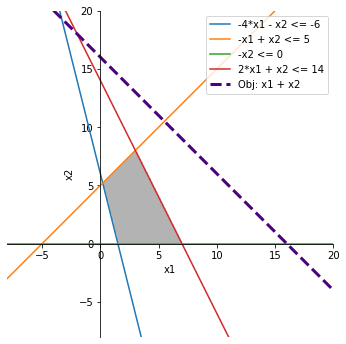

In [15]:
c = 2

Lp2 = pulp.LpProblem("My_LP_2", pulp.LpMaximize)

x1 = pulp.LpVariable('x1', lowBound=0, cat=pulp.LpContinuous)
x2 = pulp.LpVariable('x2', lowBound=0, cat=pulp.LpContinuous)

Lp2 +=    x1 +   x2

Lp2 += -4*x1 - 1*x2 <= -8+c
Lp2 += -1*x1 + 1*x2 <=  3+c
Lp2 +=       - 1*x2 <= -2+c
Lp2 +=  2*x1 + 1*x2 <= 12+c

plotLP(Lp2, x_lower=-8, x_upper=20, y_lower=-8, y_upper=20)

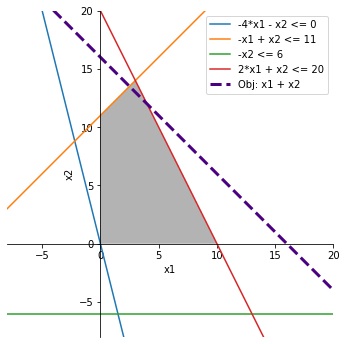

In [16]:
c = 8

Lp2 = pulp.LpProblem("My_LP_2", pulp.LpMaximize)

x1 = pulp.LpVariable('x1', lowBound=0, cat=pulp.LpContinuous)
x2 = pulp.LpVariable('x2', lowBound=0, cat=pulp.LpContinuous)

Lp2 +=    x1 +   x2

Lp2 += -4*x1 - 1*x2 <= -8+c
Lp2 += -1*x1 + 1*x2 <=  3+c
Lp2 +=       - 1*x2 <= -2+c
Lp2 +=  2*x1 + 1*x2 <= 12+c

plotLP(Lp2, x_lower=-8, x_upper=20, y_lower=-8, y_upper=20)

Choosing $c<0$ means moving the constraints to the inside, or shirinking the whole feasible region. Note that this can leads to an empty feasible region and is of no interest in the simplex method.

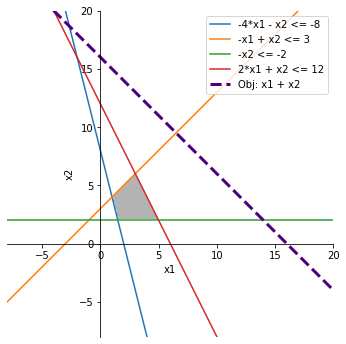

In [17]:
c = 0

Lp2 = pulp.LpProblem("My_LP_2", pulp.LpMaximize)

x1 = pulp.LpVariable('x1', lowBound=0, cat=pulp.LpContinuous)
x2 = pulp.LpVariable('x2', lowBound=0, cat=pulp.LpContinuous)

Lp2 +=    x1 +   x2

Lp2 += -4*x1 - 1*x2 <= -8+c
Lp2 += -1*x1 + 1*x2 <=  3+c
Lp2 +=       - 1*x2 <= -2+c
Lp2 +=  2*x1 + 1*x2 <= 12+c

plotLP(Lp2, x_lower=-8, x_upper=20, y_lower=-8, y_upper=20)

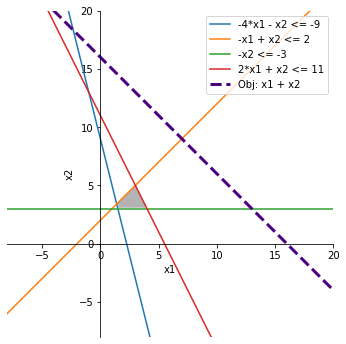

In [18]:
c = -1

Lp2 = pulp.LpProblem("My_LP_2", pulp.LpMaximize)

x1 = pulp.LpVariable('x1', lowBound=0, cat=pulp.LpContinuous)
x2 = pulp.LpVariable('x2', lowBound=0, cat=pulp.LpContinuous)

Lp2 +=    x1 +   x2

Lp2 += -4*x1 - 1*x2 <= -8+c
Lp2 += -1*x1 + 1*x2 <=  3+c
Lp2 +=       - 1*x2 <= -2+c
Lp2 +=  2*x1 + 1*x2 <= 12+c

plotLP(Lp2, x_lower=-8, x_upper=20, y_lower=-8, y_upper=20)

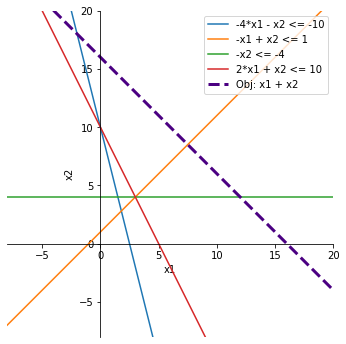

In [19]:
c = -2

Lp2 = pulp.LpProblem("My_LP_2", pulp.LpMaximize)

x1 = pulp.LpVariable('x1', lowBound=0, cat=pulp.LpContinuous)
x2 = pulp.LpVariable('x2', lowBound=0, cat=pulp.LpContinuous)

Lp2 +=    x1 +   x2

Lp2 += -4*x1 - 1*x2 <= -8+c
Lp2 += -1*x1 + 1*x2 <=  3+c
Lp2 +=       - 1*x2 <= -2+c
Lp2 +=  2*x1 + 1*x2 <= 12+c

plotLP(Lp2, x_lower=-8, x_upper=20, y_lower=-8, y_upper=20)